# Setup and Data

In [1]:
from inflation_analysis import calculate_price_indexes, output_data, output_obs_table, price_index_over_time, top_abs_weight_differences, top_price_index_contributors, grouping, index_comparison

In [2]:
# Parameters
start_year = 2019
end_year = 2022
top_n = 5
comparison_level = 'primary'
data_folder="/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/"
base_year = start_year
comparison_year = end_year

In [3]:
# Get IDs ('misparmb') of all groups
nationality, observance, income, ses, age, total_misparmb = grouping(start_year, end_year)

In [4]:
# Prepare data: calculate price indexes for each group, {comparison_level} and primary categories, and total
nationality_analysis, nationality_mmb = output_data(nationality, start_year, end_year, base_year, data_folder)
observance_analysis, observance_mmb = output_data(observance, start_year, end_year, base_year, data_folder)
income_analysis, income_mmb = output_data(income, start_year, end_year, base_year, data_folder)
ses_analysis, ses_mmb = output_data(ses, start_year, end_year, base_year, data_folder)
age_analysis, age_mmb = output_data(age, start_year, end_year, base_year, data_folder)


# General population
gen_pop_df, gen_pop_secondary_df, gen_pop_primary_df, gen_pop_yearly_price_index = calculate_price_indexes(start_year, end_year, base_year, cex_data_folder=data_folder)
gen_pop = {
    'combined_secondary_df': gen_pop_secondary_df,
    'combined_primary_df': gen_pop_primary_df,
    'yearly_price_index': gen_pop_yearly_price_index
}

Processing group 1/3 (Arab)
Processing group 2/3 (Jewish)
Processing group 3/3 (Other)
Processing group 1/5 (Secular)
Processing group 2/5 (Conservative)
Processing group 3/5 (Religious)
Processing group 4/5 (Haredi)
Processing group 5/5 (Mixed)
Processing group 1/5 (1)
Processing group 2/5 (2)
Processing group 3/5 (3)
Processing group 4/5 (4)
Processing group 5/5 (5)
Processing group 1/3 (1)
Processing group 2/3 (2)
Processing group 3/3 (3)
Processing group 1/3 (Young)
Processing group 2/3 (Middle)
Processing group 3/3 (Old)


# Output

## Tables

In [5]:
# Observations tables
output_obs_table(start_year, end_year, nationality_mmb)

,2019,2020,2021,2022
Arab,1103 (14.12%),513 (9.27%),951 (15.79%),727 (13.31%)
Jewish,6393 (81.85%),4920 (88.94%),4911 (81.52%),4584 (83.91%)
Other,331 (4.24%),160 (2.89%),195 (3.24%),167 (3.06%)
Total,7811 (100.0%),5532 (100.0%),6024 (100.0%),5463 (100.0%)


In [6]:
output_obs_table(start_year, end_year, observance_mmb)

,2019,2020,2021,2022
Secular,3668 (46.96%),2750 (49.71%),2690 (44.65%),2294 (41.99%)
Conservative,2117 (27.1%),1460 (26.39%),1577 (26.18%),1602 (29.32%)
Religious,1218 (15.59%),809 (14.62%),1035 (17.18%),808 (14.79%)
Haredi,565 (7.23%),440 (7.95%),551 (9.15%),595 (10.89%)
Mixed,218 (2.79%),99 (1.79%),168 (2.79%),145 (2.65%)
Total,7811 (100.0%),5532 (100.0%),6024 (100.0%),5463 (100.0%)


In [7]:
output_obs_table(start_year, end_year, income_mmb)

,2019,2020,2021,2022
1,1356 (17.36%),871 (15.74%),1020 (16.93%),1052 (19.26%)
2,1467 (18.78%),978 (17.68%),1111 (18.44%),1116 (20.43%)
3,1524 (19.51%),1087 (19.65%),1197 (19.87%),1061 (19.42%)
4,1632 (20.89%),1225 (22.14%),1250 (20.75%),1087 (19.9%)
5,1848 (23.66%),1432 (25.89%),1479 (24.55%),1162 (21.27%)
Total,7811 (100.0%),5532 (100.0%),6024 (100.0%),5463 (100.0%)


In [8]:
output_obs_table(start_year, end_year, income_mmb)

,2019,2020,2021,2022
1,1356 (17.36%),871 (15.74%),1020 (16.93%),1052 (19.26%)
2,1467 (18.78%),978 (17.68%),1111 (18.44%),1116 (20.43%)
3,1524 (19.51%),1087 (19.65%),1197 (19.87%),1061 (19.42%)
4,1632 (20.89%),1225 (22.14%),1250 (20.75%),1087 (19.9%)
5,1848 (23.66%),1432 (25.89%),1479 (24.55%),1162 (21.27%)
Total,7811 (100.0%),5532 (100.0%),6024 (100.0%),5463 (100.0%)


In [9]:
output_obs_table(start_year, end_year, ses_mmb)

,2019,2020,2021,2022
1,2163 (27.69%),1371 (24.78%),2008 (33.33%),1964 (35.95%)
2,1911 (24.47%),1490 (26.93%),1503 (24.95%),1352 (24.75%)
3,3753 (48.05%),2719 (49.15%),2546 (42.26%),2162 (39.58%)
Total,7811 (100.0%),5532 (100.0%),6024 (100.0%),5463 (100.0%)


## Plots

### Yearly Price Index Comparison Between Groups

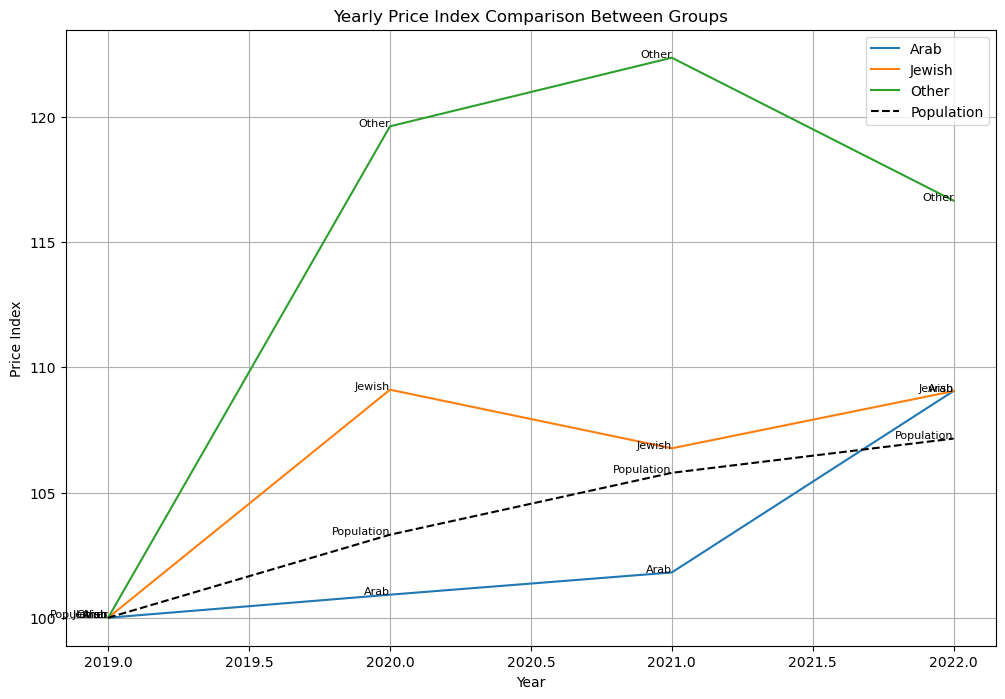

In [10]:
price_index_over_time(nationality_analysis, gen_pop_yearly_price_index)

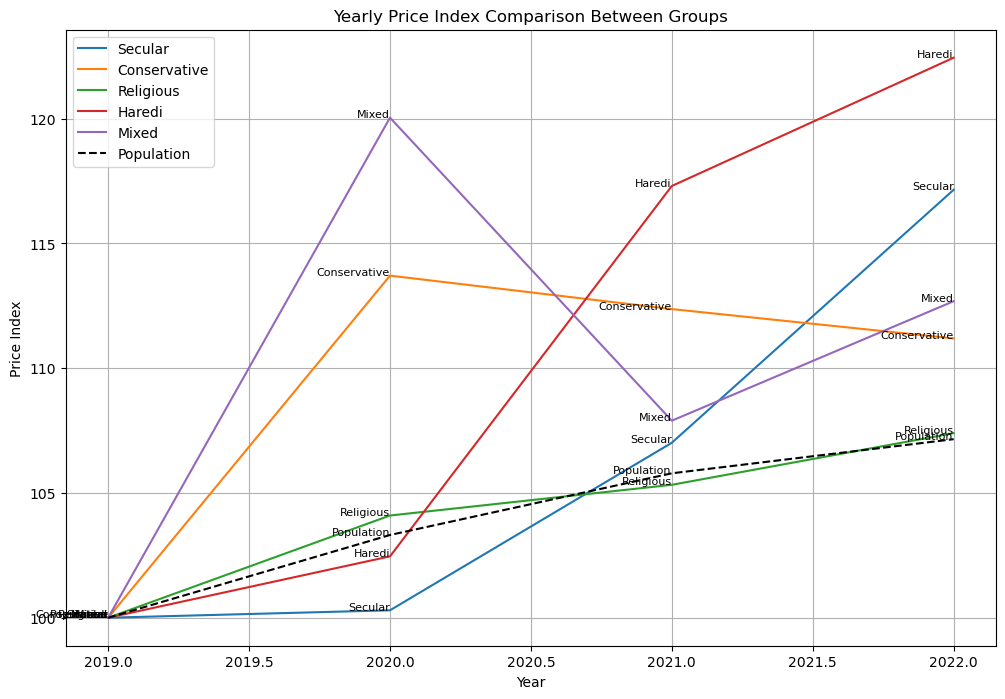

In [11]:
price_index_over_time(observance_analysis, gen_pop_yearly_price_index)

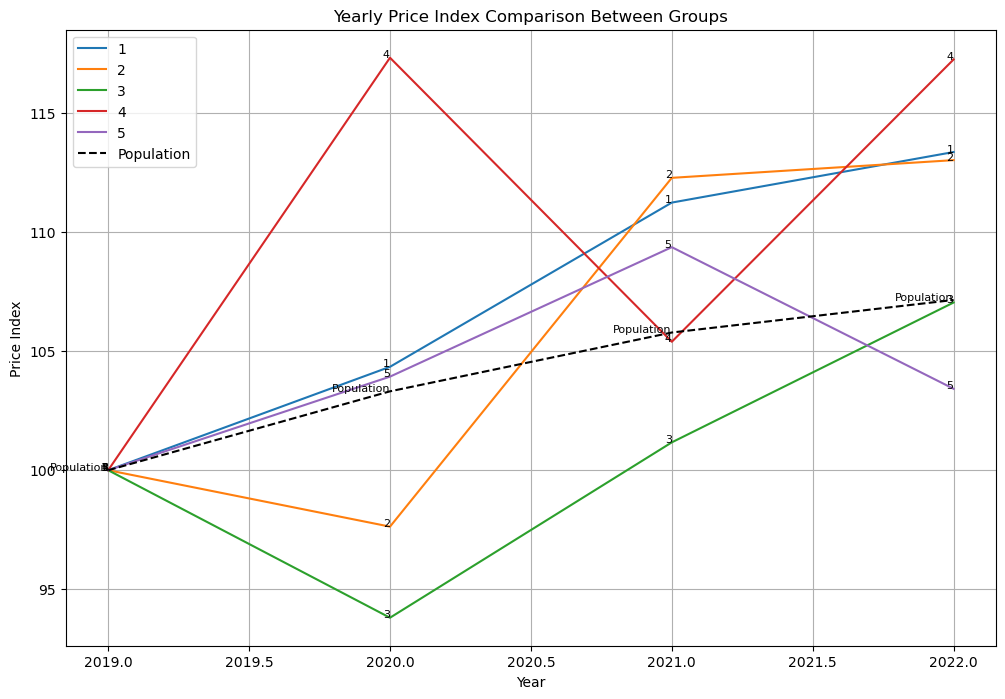

In [12]:
price_index_over_time(income_analysis, gen_pop_yearly_price_index)

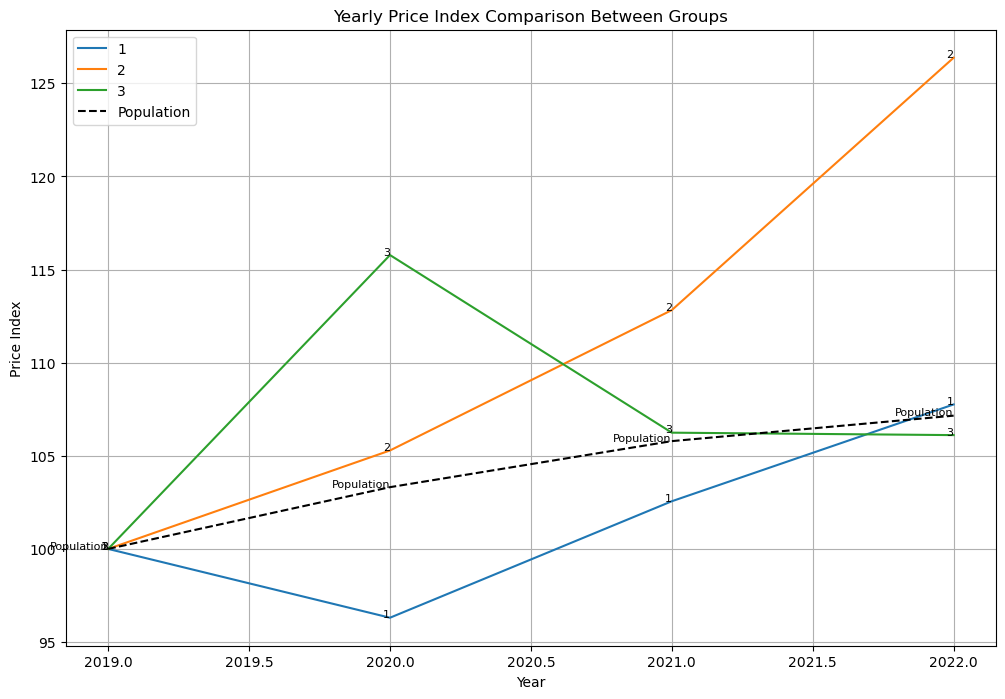

In [13]:
price_index_over_time(ses_analysis, gen_pop_yearly_price_index)

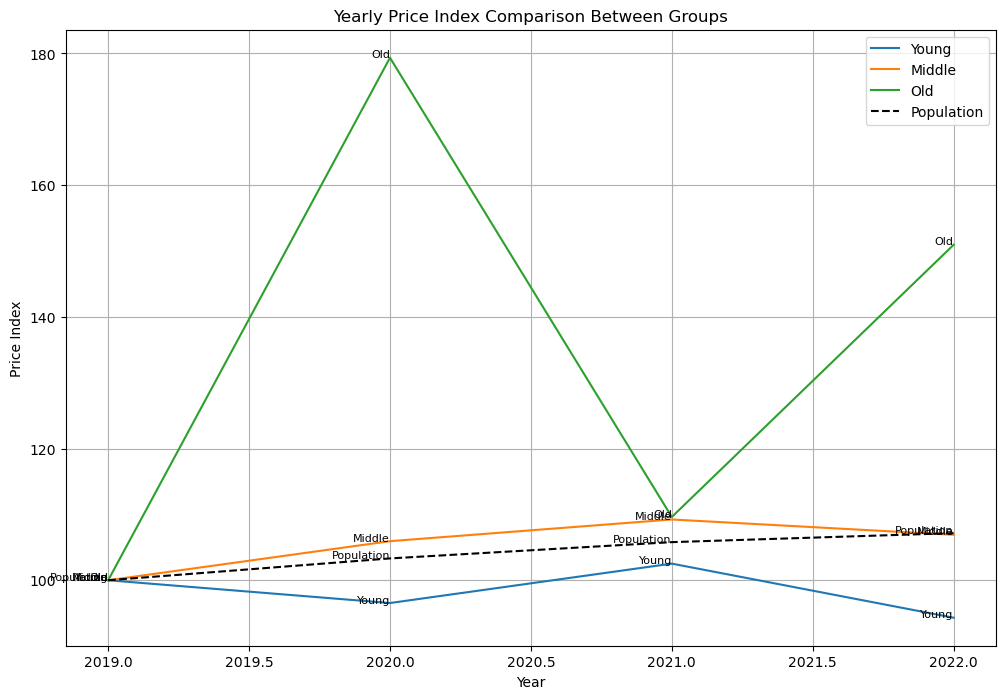

In [14]:
price_index_over_time(age_analysis, gen_pop_yearly_price_index)

### Top Weight Differences

In [15]:
# Define control group
weights_comparison_control = gen_pop[f'combined_{comparison_level}_df'][gen_pop[f'combined_{comparison_level}_df']['Year'] == comparison_year]

,Year,prodcode,price_index,weight,description,weight_diff
36,2022,36,91.471453,0.047599,Health Total,-0.008884
38,2022,38,103.125166,0.155497,Transport And Communication Total,-0.013498
34,2022,34,90.326452,0.037522,Furniture And Household Equipment Total,-0.015265
37,2022,37,135.156040,0.079441,Education Culture And Entertainment Total,-0.017270
30,2022,30,127.469189,0.271385,Food Total Excluding Fruits And Vegetables,-0.024462
33,2022,33,93.246709,0.157170,Dwelling And Household Maintenance Total,0.063198
35,2022,35,95.846499,0.077965,Clothing And Footwear Total,0.015226
39,2022,39,89.769365,0.087797,Miscellaneous Goods And Services Total,0.008520
32,2022,32,117.242943,0.016776,Housing Total,-0.003683
31,2022,31,115.804904,0.068849,Vegetables And Fruits Total,-0.003882


,Year,prodcode,price_index,weight,description,weight_diff
31,2022,31,103.402855,0.074709,Vegetables And Fruits Total,0.001978
32,2022,32,98.078001,0.019709,Housing Total,-0.000750
35,2022,35,100.922571,0.059061,Clothing And Footwear Total,-0.003678
39,2022,39,110.885081,0.070459,Miscellaneous Goods And Services Total,-0.008817
33,2022,33,127.826682,0.080928,Dwelling And Household Maintenance Total,-0.013044
30,2022,30,110.095645,0.305098,Food Total Excluding Fruits And Vegetables,0.009251
38,2022,38,105.774166,0.174522,Transport And Communication Total,0.005528
37,2022,37,100.751494,0.100983,Education Culture And Entertainment Total,0.004272
36,2022,36,115.918632,0.059726,Health Total,0.003243
34,2022,34,111.812803,0.054805,Furniture And Household Equipment Total,0.002018


,Year,prodcode,price_index,weight,description,weight_diff
36,2022,36,153.160274,0.039733,Health Total,-0.016751
34,2022,34,151.865883,0.026671,Furniture And Household Equipment Total,-0.026117
33,2022,33,101.025458,0.065809,Dwelling And Household Maintenance Total,-0.028163
37,2022,37,94.542192,0.056927,Education Culture And Entertainment Total,-0.039784
38,2022,38,127.609014,0.109690,Transport And Communication Total,-0.059305
30,2022,30,113.004981,0.417879,Food Total Excluding Fruits And Vegetables,0.122032
32,2022,32,80.100030,0.064794,Housing Total,0.044335
31,2022,31,105.235708,0.095371,Vegetables And Fruits Total,0.022640
39,2022,39,161.736333,0.071639,Miscellaneous Goods And Services Total,-0.007637
35,2022,35,125.460296,0.051487,Clothing And Footwear Total,-0.011252


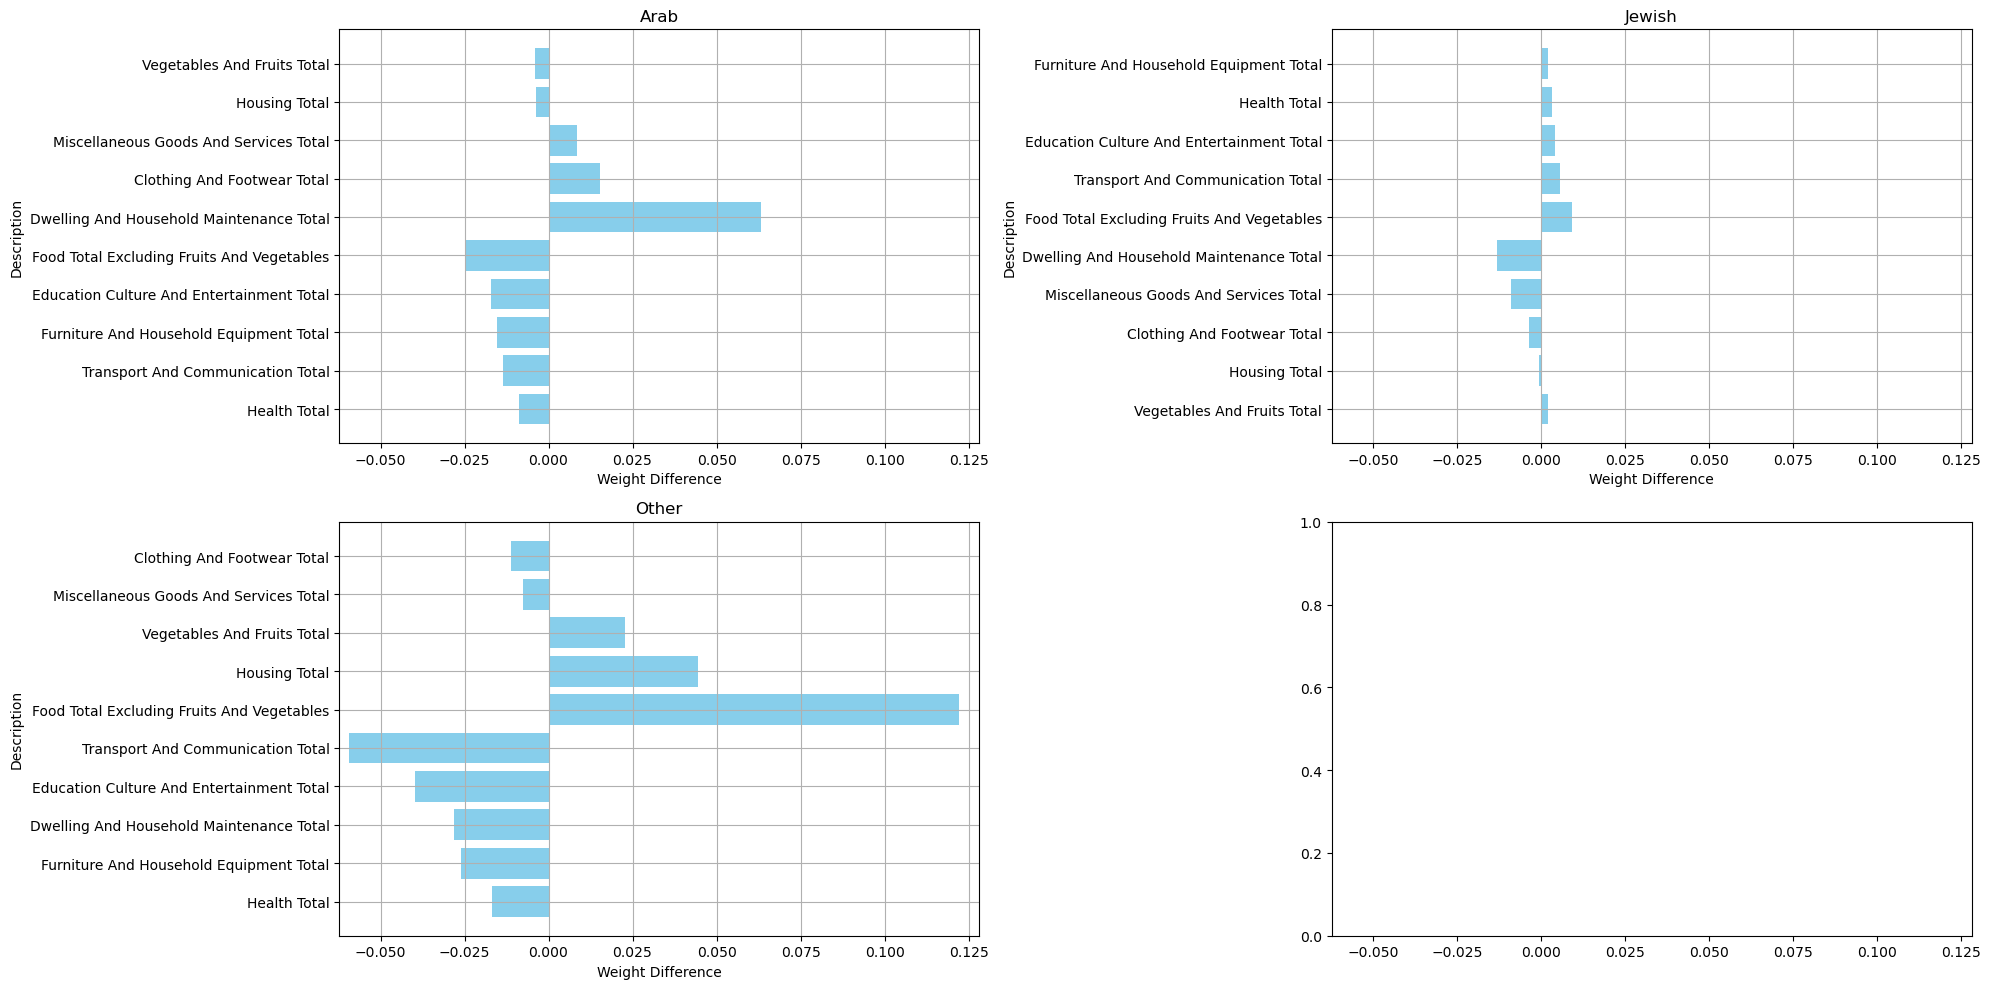

In [16]:
# Top weight differences - nationality groups
nationality_comparison_groups = {}
for group in nationality_analysis:
    nationality_comparison_groups[group] = nationality_analysis[group][f'combined_{comparison_level}_df'][nationality_analysis[group][f'combined_{comparison_level}_df']['Year'] == comparison_year]
top_abs_weight_differences(nationality_comparison_groups, weights_comparison_control, top_n)

In [17]:
index_comparison(nationality_comparison_groups, weights_comparison_control)

,group,Control,Arab,Jewish,Other
prodcode,description,,,,
30,Food Total Excluding Fruits And Vegetables,112.21(0.2958),127.47(0.2714),110.10(0.3051),113.00(0.4179)
31,Vegetables And Fruits Total,104.41(0.0727),115.80(0.0688),103.40(0.0747),105.24(0.0954)
32,Housing Total,97.04(0.0205),117.24(0.0168),98.08(0.0197),80.10(0.0648)
33,Dwelling And Household Maintenance Total,114.59(0.0940),93.25(0.1572),127.83(0.0809),101.03(0.0658)
34,Furniture And Household Equipment Total,104.85(0.0528),90.33(0.0375),111.81(0.0548),151.87(0.0267)
35,Clothing And Footwear Total,98.43(0.0627),95.85(0.0780),100.92(0.0591),125.46(0.0515)
36,Health Total,110.59(0.0565),91.47(0.0476),115.92(0.0597),153.16(0.0397)
37,Education Culture And Entertainment Total,106.99(0.0967),135.16(0.0794),100.75(0.1010),94.54(0.0569)
38,Transport And Communication Total,102.39(0.1690),103.13(0.1555),105.77(0.1745),127.61(0.1097)


,Year,prodcode,price_index,weight,description,weight_diff
34,2022,34,130.438950,0.050204,Furniture And Household Equipment Total,-0.002583
31,2022,31,103.149017,0.068281,Vegetables And Fruits Total,-0.004450
33,2022,33,161.688514,0.089441,Dwelling And Household Maintenance Total,-0.004530
39,2022,39,107.202673,0.069382,Miscellaneous Goods And Services Total,-0.009894
35,2022,35,102.445784,0.052087,Clothing And Footwear Total,-0.010652
38,2022,38,112.087906,0.181477,Transport And Communication Total,0.012483
37,2022,37,114.733166,0.107960,Education Culture And Entertainment Total,0.011249
36,2022,36,128.521199,0.060269,Health Total,0.003786
32,2022,32,99.689042,0.023274,Housing Total,0.002815
30,2022,30,112.659679,0.297623,Food Total Excluding Fruits And Vegetables,0.001776


,Year,prodcode,price_index,weight,description,weight_diff
34,2022,34,94.177915,0.052885,Furniture And Household Equipment Total,0.000098
33,2022,33,111.982258,0.092864,Dwelling And Household Maintenance Total,-0.001108
32,2022,32,93.991109,0.016164,Housing Total,-0.004295
39,2022,39,124.105535,0.072829,Miscellaneous Goods And Services Total,-0.006447
37,2022,37,143.498453,0.074342,Education Culture And Entertainment Total,-0.022369
38,2022,38,88.802315,0.182221,Transport And Communication Total,0.013226
30,2022,30,121.578390,0.303357,Food Total Excluding Fruits And Vegetables,0.007510
35,2022,35,105.153979,0.069636,Clothing And Footwear Total,0.006897
36,2022,36,103.386275,0.060291,Health Total,0.003807
31,2022,31,105.679948,0.075411,Vegetables And Fruits Total,0.002680


,Year,prodcode,price_index,weight,description,weight_diff
36,2022,36,107.020024,0.047520,Health Total,-0.008963
32,2022,32,212.860501,0.009231,Housing Total,-0.011228
34,2022,34,155.368964,0.040849,Furniture And Household Equipment Total,-0.011938
37,2022,37,101.327451,0.077741,Education Culture And Entertainment Total,-0.018970
38,2022,38,131.590673,0.148266,Transport And Communication Total,-0.020728
33,2022,33,89.683812,0.120052,Dwelling And Household Maintenance Total,0.026081
39,2022,39,72.588886,0.104071,Miscellaneous Goods And Services Total,0.024795
35,2022,35,87.406906,0.073384,Clothing And Footwear Total,0.010645
31,2022,31,105.430295,0.083163,Vegetables And Fruits Total,0.010432
30,2022,30,111.959935,0.295722,Food Total Excluding Fruits And Vegetables,-0.000125


,Year,prodcode,price_index,weight,description,weight_diff
32,2022,32,136.819172,0.011189,Housing Total,-0.009270
39,2022,39,109.002201,0.069917,Miscellaneous Goods And Services Total,-0.009359
33,2022,33,124.998353,0.066656,Dwelling And Household Maintenance Total,-0.027316
37,2022,37,134.313029,0.062581,Education Culture And Entertainment Total,-0.034130
38,2022,38,143.106102,0.093306,Transport And Communication Total,-0.075688
30,2022,30,121.349578,0.401052,Food Total Excluding Fruits And Vegetables,0.105205
31,2022,31,125.714633,0.105801,Vegetables And Fruits Total,0.033070
35,2022,35,111.369825,0.091074,Clothing And Footwear Total,0.028335
34,2022,34,110.793717,0.048761,Furniture And Household Equipment Total,-0.004027
36,2022,36,114.567689,0.049663,Health Total,-0.006820


,Year,prodcode,price_index,weight,description,weight_diff
39,2022,39,119.957990,0.075563,Miscellaneous Goods And Services Total,-0.003714
38,2022,38,NaN,0.158064,Transport And Communication Total,-0.010930
36,2022,36,136.025193,0.043563,Health Total,-0.012920
37,2022,37,100.331696,0.078390,Education Culture And Entertainment Total,-0.018321
34,2022,34,95.751510,0.024865,Furniture And Household Equipment Total,-0.027922
30,2022,30,111.442179,0.351986,Food Total Excluding Fruits And Vegetables,0.056139
31,2022,31,104.958662,0.087388,Vegetables And Fruits Total,0.014657
32,2022,32,210.526316,0.022913,Housing Total,0.002454
35,2022,35,137.863418,0.063077,Clothing And Footwear Total,0.000338
33,2022,33,99.437712,0.094191,Dwelling And Household Maintenance Total,0.000219


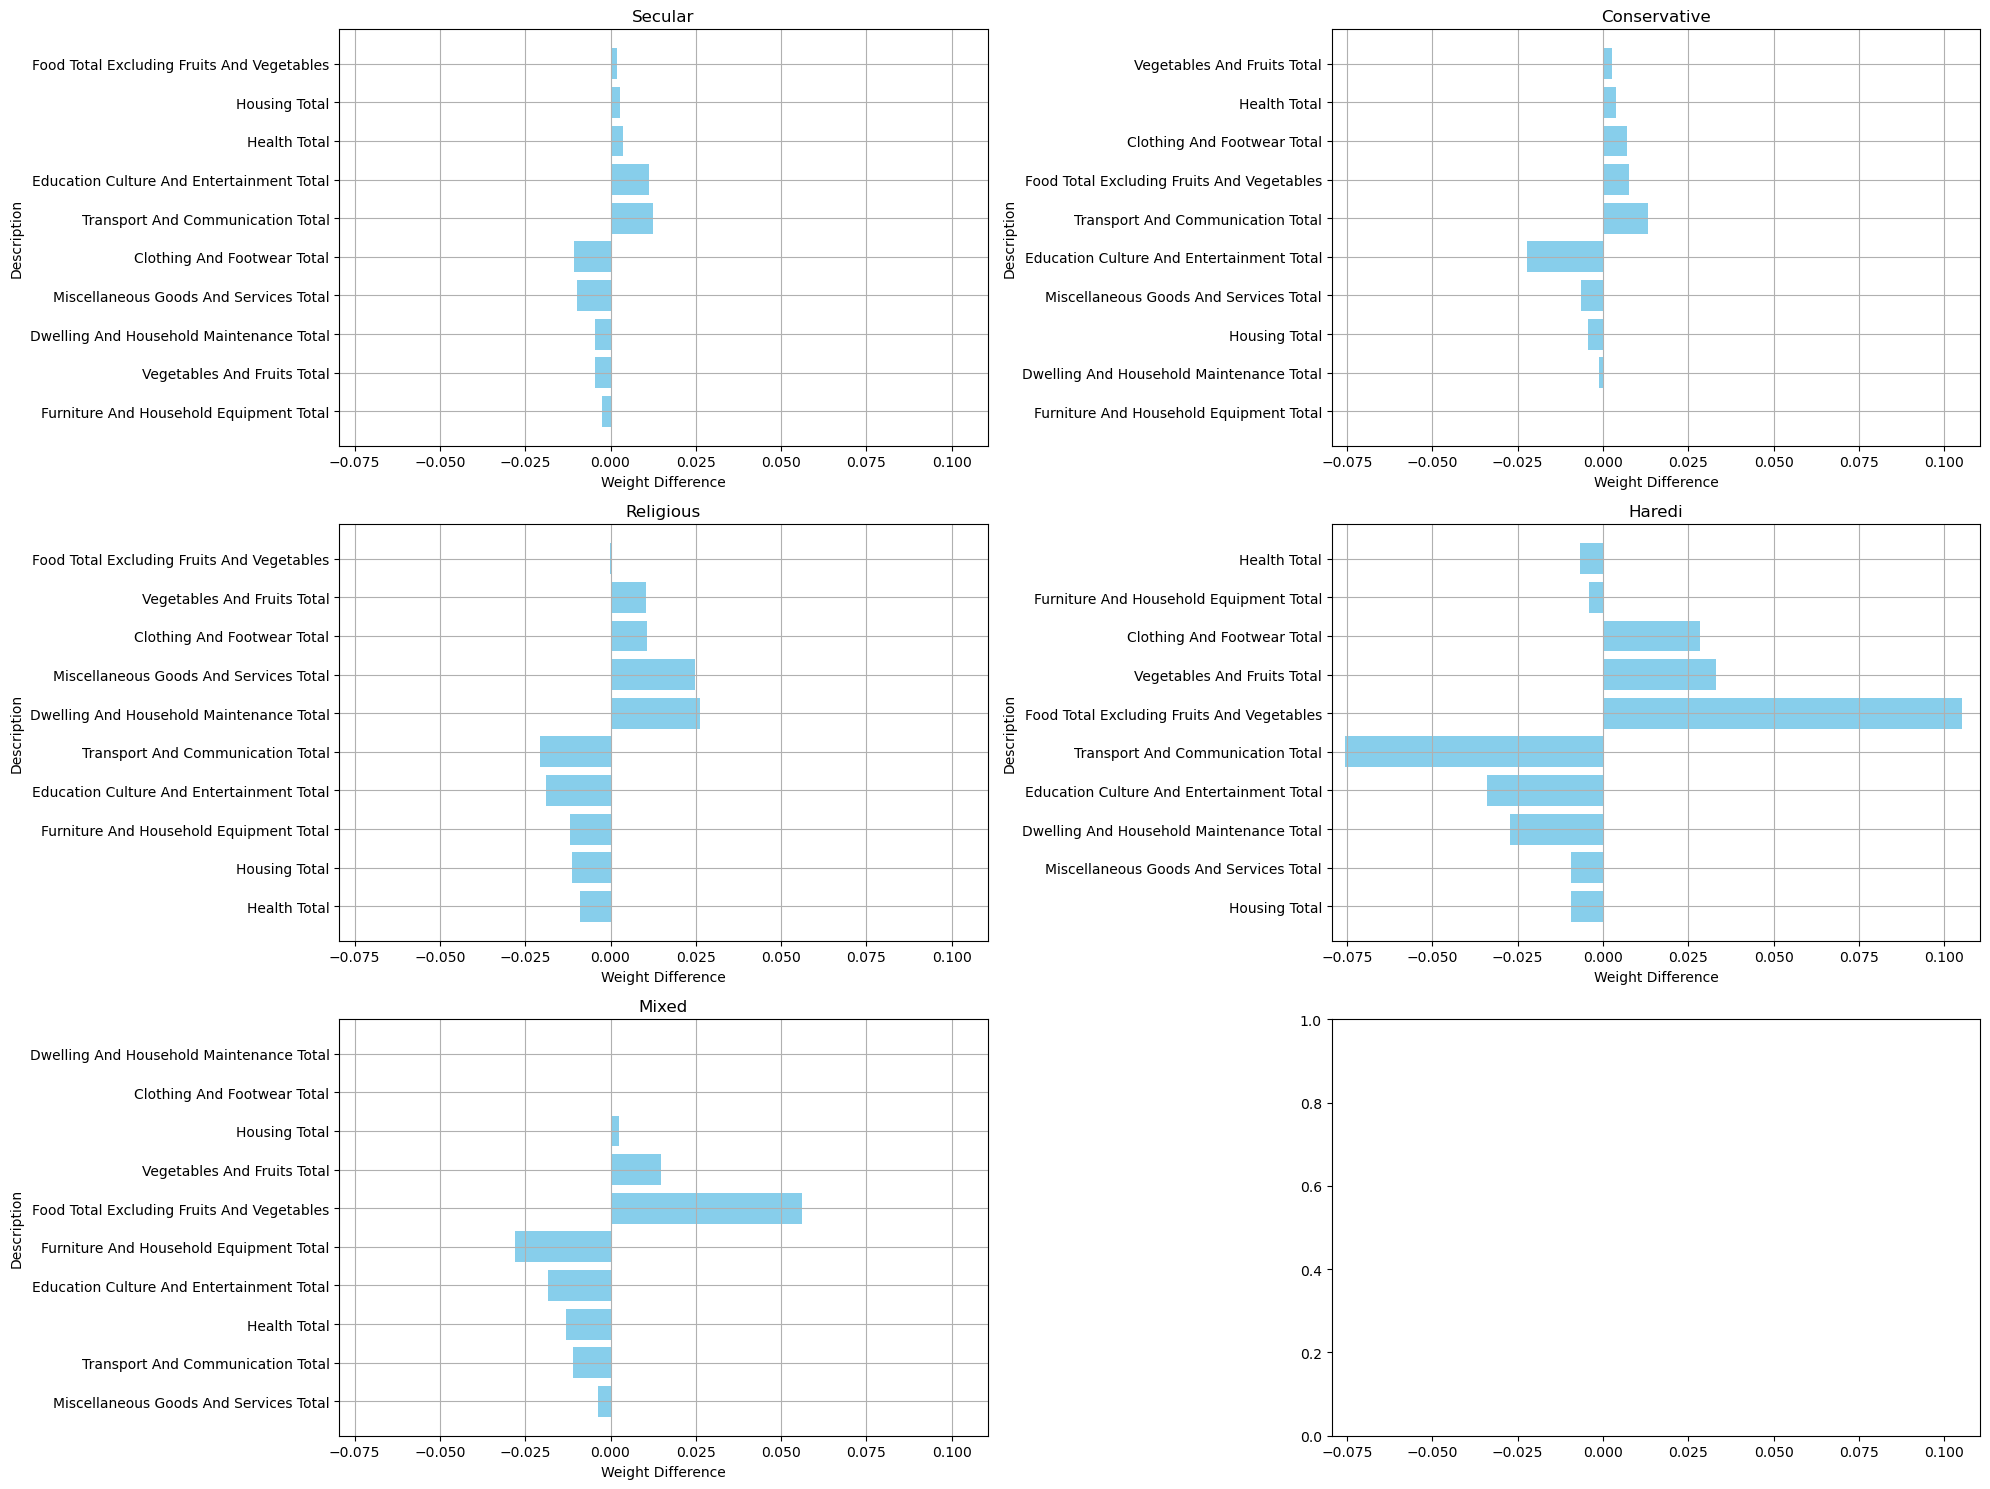

In [18]:
observance_comparison_groups = {}
for group in observance_analysis:
    observance_comparison_groups[group] = observance_analysis[group][f'combined_{comparison_level}_df'][observance_analysis[group][f'combined_{comparison_level}_df']['Year'] == comparison_year]
top_abs_weight_differences(observance_comparison_groups, weights_comparison_control, top_n)

In [ ]:
index_comparison(observance_comparison_groups, weights_comparison_control)

In [ ]:
# Top weight differences - income groups
income_comparison_groups = {}
for group in income_analysis:
    income_comparison_groups[group] = income_analysis[group][f'combined_{comparison_level}_df'][income_analysis[group][f'combined_{comparison_level}_df']['Year'] == comparison_year]
top_abs_weight_differences(income_comparison_groups, weights_comparison_control, top_n)

In [ ]:
index_comparison(income_comparison_groups, weights_comparison_control)

In [ ]:
# Top weight differences - SES groups
ses_comparison_groups = {}
for group in ses_analysis:
    ses_comparison_groups[group] = ses_analysis[group][f'combined_{comparison_level}_df'][ses_analysis[group][f'combined_{comparison_level}_df']['Year'] == comparison_year]
top_abs_weight_differences(ses_comparison_groups, weights_comparison_control, top_n)

In [ ]:
index_comparison(ses_comparison_groups, weights_comparison_control)

In [ ]:
# Top weight differences - age groups
age_comparison_groups = {}
for group in age_analysis:
    age_comparison_groups[group] = age_analysis[group][f'combined_{comparison_level}_df'][age_analysis[group][f'combined_{comparison_level}_df']['Year'] == comparison_year]
top_abs_weight_differences(age_comparison_groups, weights_comparison_control, top_n)

In [ ]:
index_comparison(age_comparison_groups, weights_comparison_control)

### Top Contributors to CPI Change

,Year,prodcode,price_index,weight,description,contribution
35,2022,35,95.846499,0.077965,Clothing And Footwear Total,-3.574844
34,2022,34,90.326452,0.037522,Furniture And Household Equipment Total,-4.006944
36,2022,36,91.471453,0.047599,Health Total,-4.481426
39,2022,39,89.769365,0.087797,Miscellaneous Goods And Services Total,-9.915660
33,2022,33,93.246709,0.157170,Dwelling And Household Maintenance Total,-11.717240
30,2022,30,127.469189,0.271385,Food Total Excluding Fruits And Vegetables,82.294924
37,2022,37,135.156040,0.079441,Education Culture And Entertainment Total,30.830973
31,2022,31,115.804904,0.068849,Vegetables And Fruits Total,12.012377
38,2022,38,103.125166,0.155497,Transport And Communication Total,5.364579
32,2022,32,117.242943,0.016776,Housing Total,3.193262


,Year,prodcode,price_index,weight,description,contribution
34,2022,34,111.812803,0.054805,Furniture And Household Equipment Total,7.152332
31,2022,31,103.402855,0.074709,Vegetables And Fruits Total,2.808584
37,2022,37,100.751494,0.100983,Education Culture And Entertainment Total,0.838389
35,2022,35,100.922571,0.059061,Clothing And Footwear Total,0.601965
32,2022,32,98.078001,0.019709,Housing Total,-0.418495
30,2022,30,110.095645,0.305098,Food Total Excluding Fruits And Vegetables,34.028633
33,2022,33,127.826682,0.080928,Dwelling And Household Maintenance Total,24.878942
38,2022,38,105.774166,0.174522,Transport And Communication Total,11.132954
36,2022,36,115.918632,0.059726,Health Total,10.503646
39,2022,39,110.885081,0.070459,Miscellaneous Goods And Services Total,8.473049


,Year,prodcode,price_index,weight,description,contribution
35,2022,35,125.460296,0.051487,Clothing And Footwear Total,7.869044
31,2022,31,105.235708,0.095371,Vegetables And Fruits Total,2.997425
33,2022,33,101.025458,0.065809,Dwelling And Household Maintenance Total,0.405099
37,2022,37,94.542192,0.056927,Education Culture And Entertainment Total,-1.865075
32,2022,32,80.100030,0.064794,Housing Total,-7.740049
30,2022,30,113.004981,0.417879,Food Total Excluding Fruits And Vegetables,32.622450
39,2022,39,161.736333,0.071639,Miscellaneous Goods And Services Total,26.549098
38,2022,38,127.609014,0.109690,Transport And Communication Total,18.179127
36,2022,36,153.160274,0.039733,Health Total,12.679169
34,2022,34,151.865883,0.026671,Furniture And Household Equipment Total,8.303711


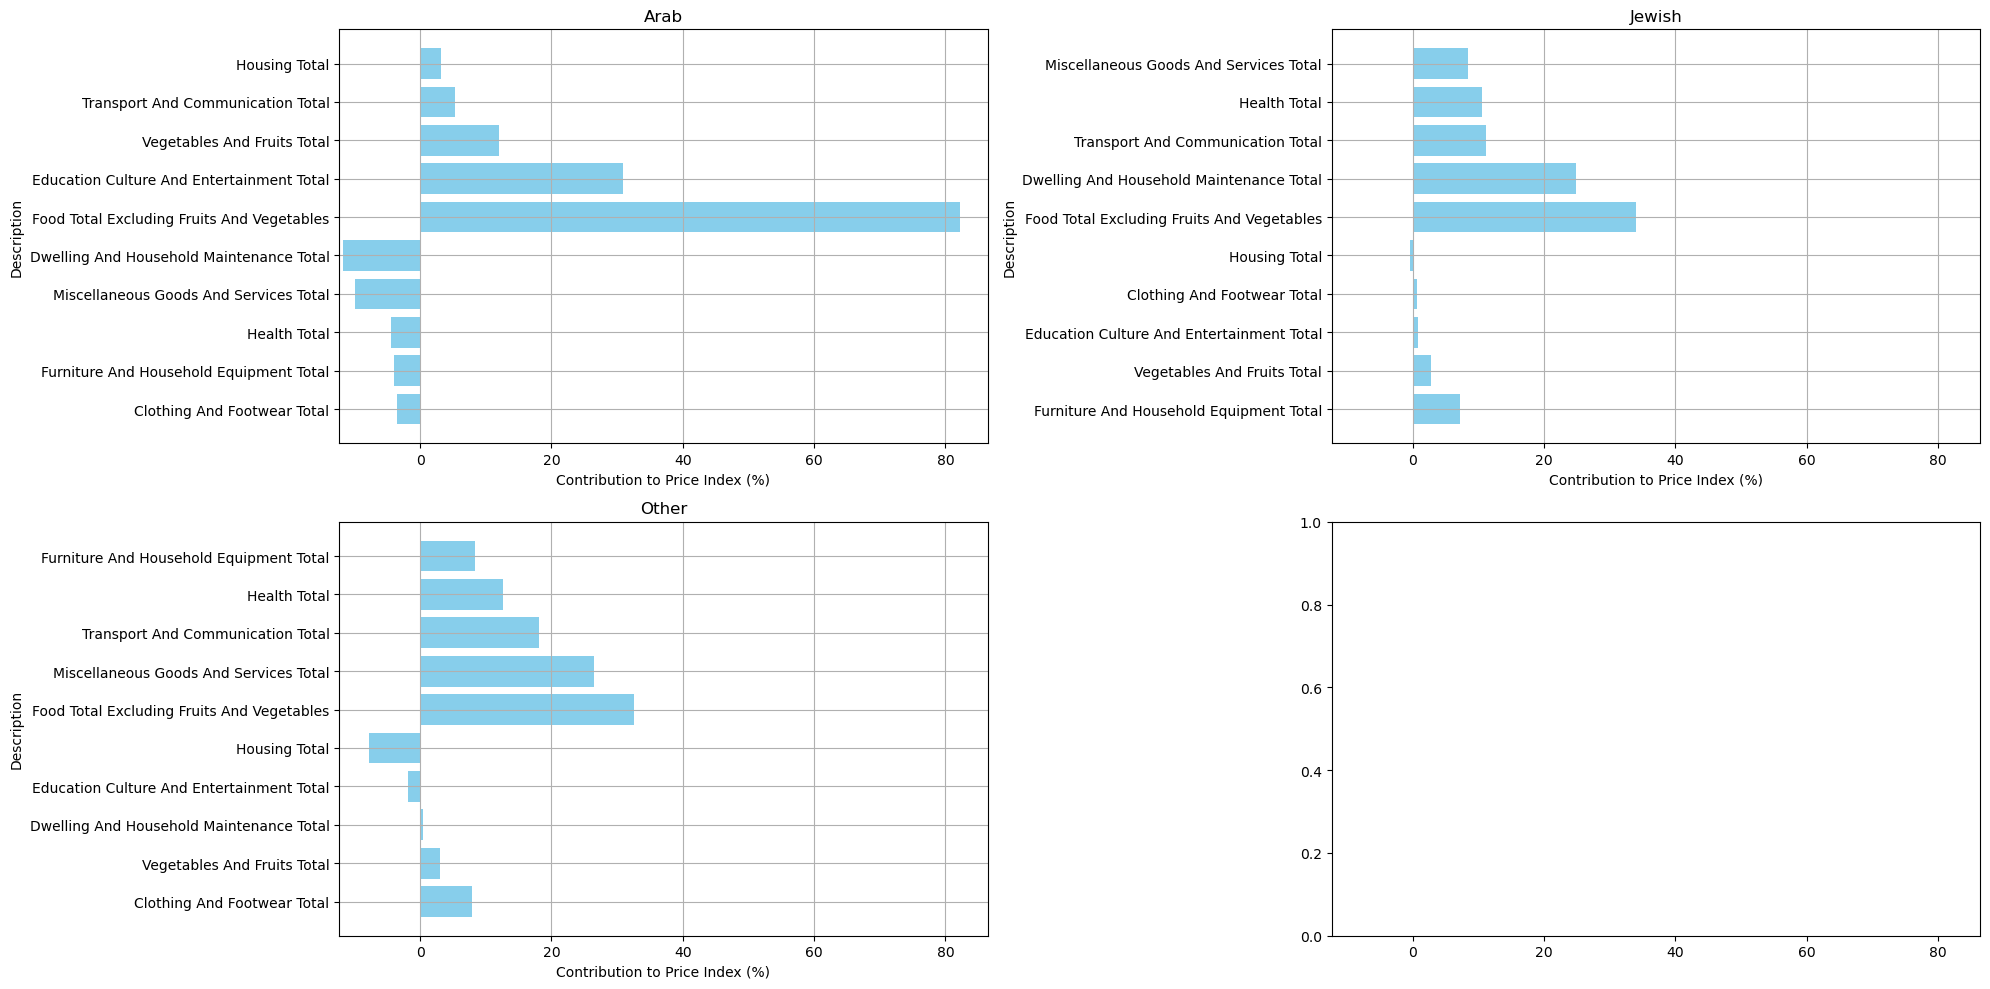

In [19]:
# Top contributors - nationality groups
nationality_yearly_price_indexes = {}
for group in nationality_analysis:
    nationality_yearly_price_indexes[group] = nationality_analysis[group]['yearly_price_index'][comparison_year]
top_price_index_contributors(nationality_comparison_groups, nationality_yearly_price_indexes, top_n)

In [ ]:
# Top contributors - observance groups
observance_yearly_price_indexes = {}
for group in observance_analysis:
    observance_yearly_price_indexes[group] = observance_analysis[group]['yearly_price_index'][comparison_year]
top_price_index_contributors(observance_comparison_groups, observance_yearly_price_indexes, top_n)

In [ ]:
# Top contributors - income groups
income_yearly_price_indexes = {}
for group in income_analysis:
    income_yearly_price_indexes[group] = income_analysis[group]['yearly_price_index'][comparison_year]
top_price_index_contributors(income_comparison_groups, income_yearly_price_indexes, top_n)

In [ ]:
# Top contributors - SES groups
ses_yearly_price_indexes = {}
for group in ses_analysis:
    ses_yearly_price_indexes[group] = ses_analysis[group]['yearly_price_index'][comparison_year]
top_price_index_contributors(ses_comparison_groups, ses_yearly_price_indexes, top_n)

In [ ]:
# Top contributors - age groups
age_yearly_price_indexes = {}
for group in age_analysis:
    age_yearly_price_indexes[group] = age_analysis[group]['yearly_price_index'][comparison_year]
top_price_index_contributors(age_comparison_groups, age_yearly_price_indexes, top_n)

In [ ]:
# Export to html [--no-input]
!jupyter nbconvert --to html Tri_Group_inflation_comparison.ipynb --output Group_inflation_{comparison_level}_top_{top_n}.html 